## Kaggle: House Price Prediction
2019 2nd ML month with KaKR
캐글 코리아와 함께하는 2nd ML 대회

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

## 1. 데이터 살펴보기

In [2]:
# 파일 경로
data_dir = os.getenv('HOME')+'/aiffel/lms_project_dataset/EP6'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로
print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/lms_project_dataset/EP6/train.csv
/aiffel/aiffel/lms_project_dataset/EP6/test.csv


In [3]:
# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape)) #train data dim : (15035, 21)
print('sub data dim : {}'.format(sub.shape)) #sub data dim : (6468, 20)

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
# 학습 데이터에서 라벨 제거하기
y = data['price']
del data['price']

In [5]:
train_len = len(data) #train data갯수 알아야 한다. 
print(train_len)
data = pd.concat((data, sub), axis=0)
print(len(data))
data.head()

15035
21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다

<AxesSubplot:>

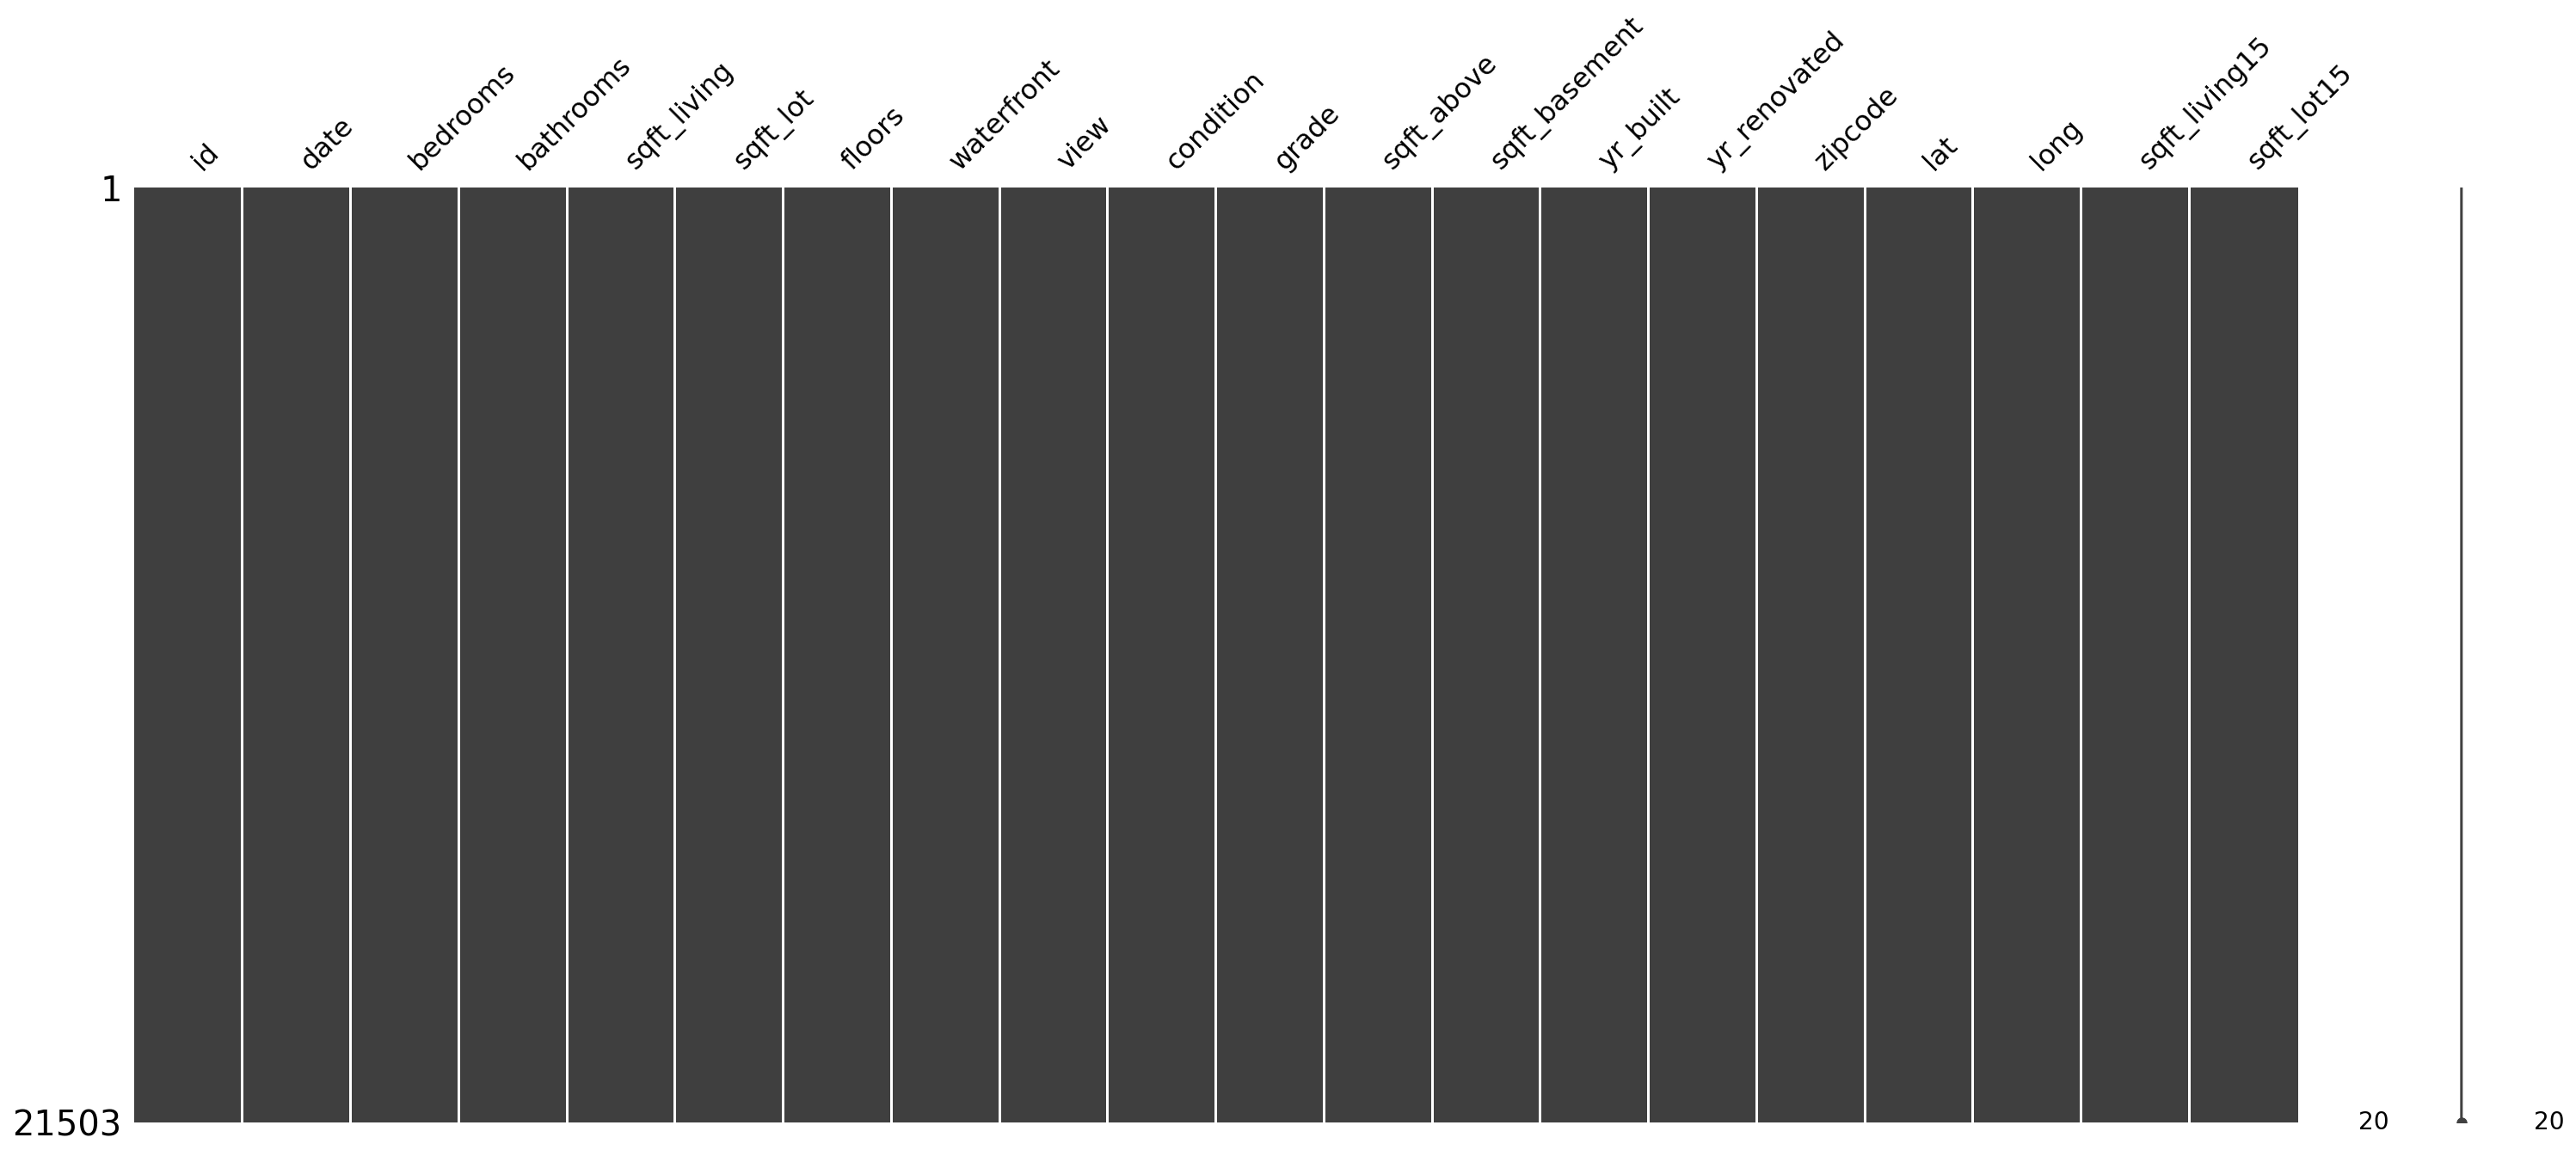

In [6]:
msno.matrix(data) # DataFrame을 매트릭스 모양 그대로 시각화

In [7]:
# 컬럼별 데이터 결측치 갯수 
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수정리와 추가 열 만들기

In [8]:
# 추가 열만들기 
data['sqrt_total']=data['sqft_above']+data['sqft_basement'] #전체집 면적
data['yr_use']=data['yr_built'].max()-data['yr_built'] # 사용년도 

In [9]:
# id, date 변수 정리
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : int(x[:6]))
print(data.columns)
data.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqrt_total', 'yr_use'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqrt_total,yr_use
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,1180,60
1,201502,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,770,82
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,1680,28
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,...,0,1995,0,98003,47.3097,-122.327,2238,6819,1715,20
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,...,0,1963,0,98198,47.4095,-122.315,1650,9711,1060,52


### 각 변수들의 분포 확인

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqrt_total', 'yr_use'],
      dtype='object')


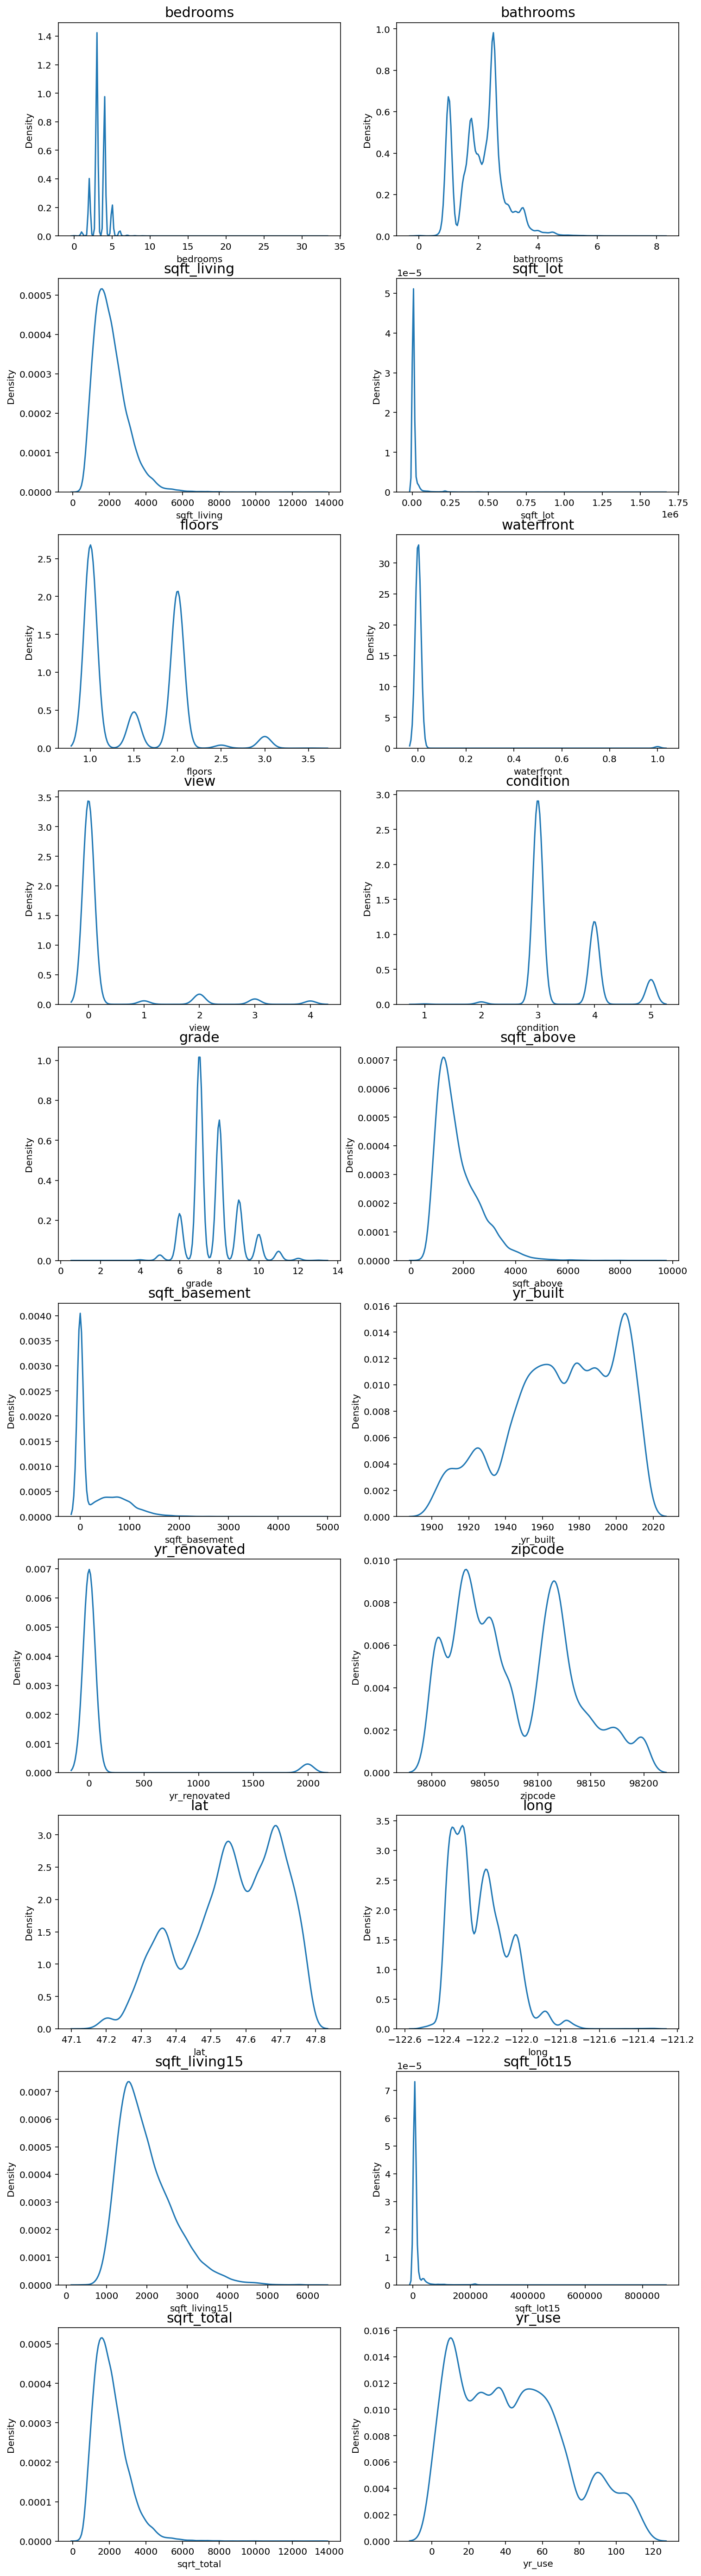

In [10]:
# 각 변수들의 분포 시각화 
fig, ax = plt.subplots(10, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 
# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
print(data.columns)
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 21:
            break

In [11]:
# 데이터분포를 정규분포화시킴 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15', 'sqrt_total']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

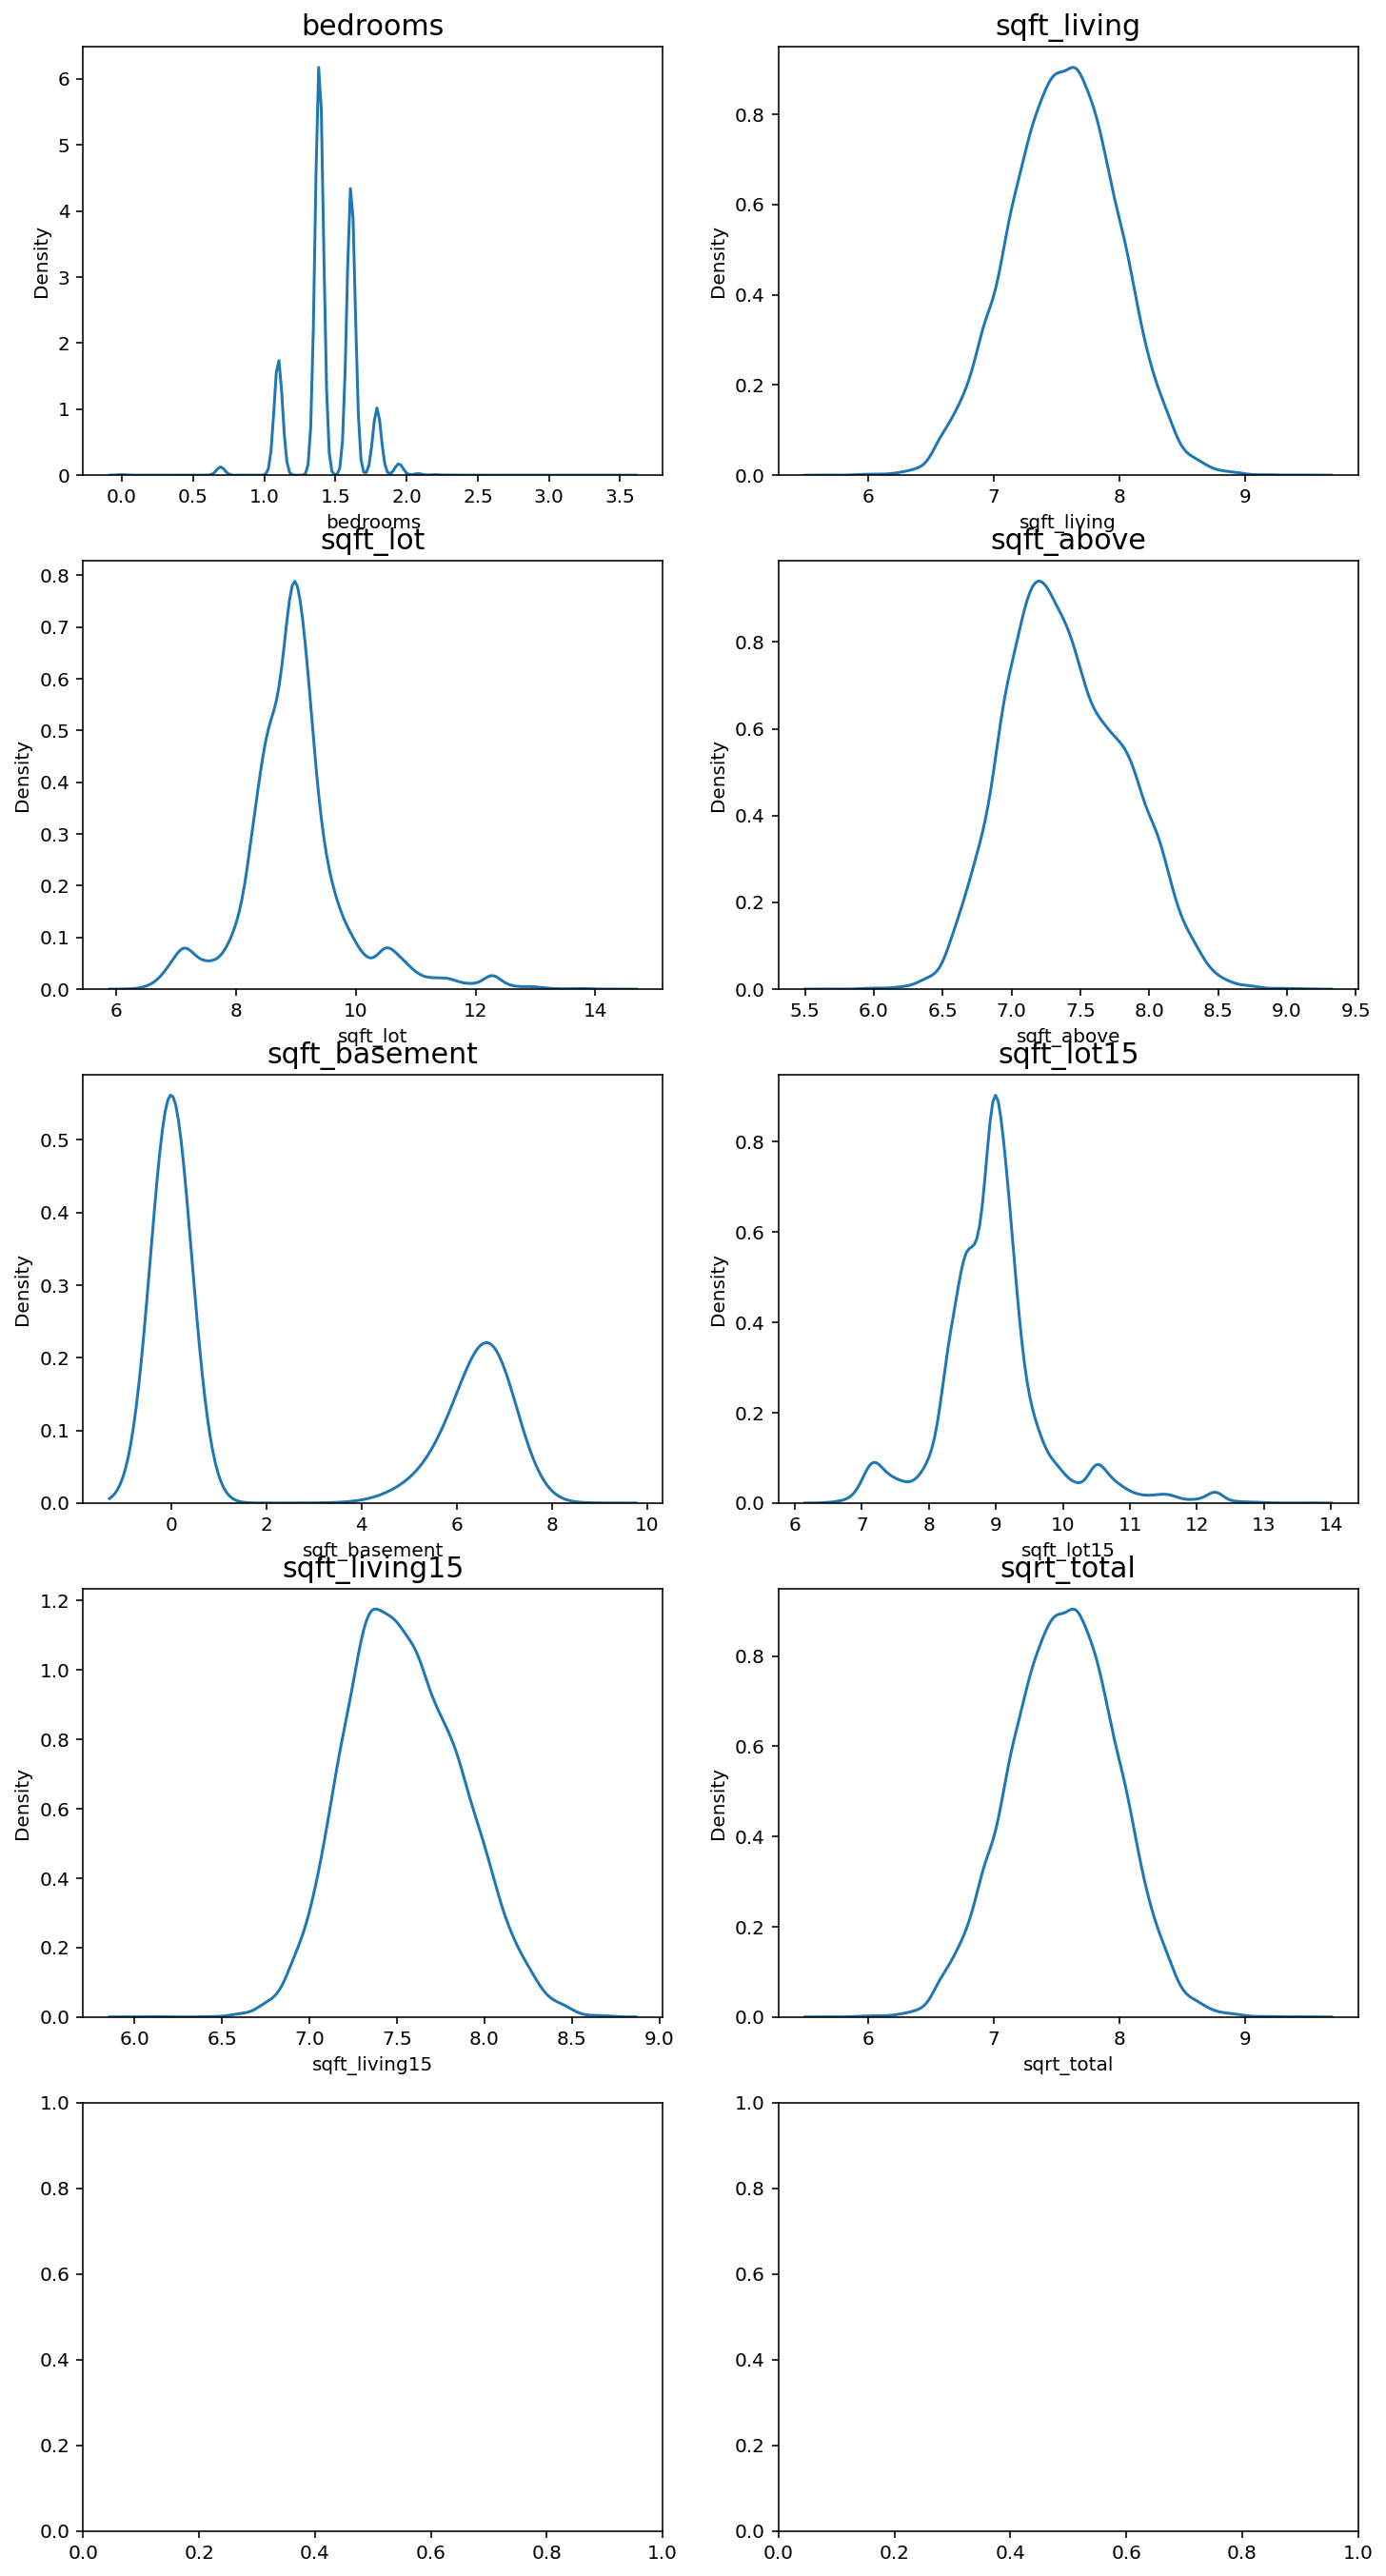

In [12]:
# log변환이 된 후의 분포를 다시 한 번 확인
fig, ax = plt.subplots(5, 2, figsize=(12, 24))
count = 0
for row in range(5):
    for col in range(2):
        if count == len(skew_columns):
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### train, test set 분리

In [13]:
x = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]
print(x.shape) # (15035, 19)
print(sub.shape) # (6468, 19)

(15035, 21)
(6468, 21)


## 3. 모델링
### Average Blending

In [14]:
# gboost = GradientBoostingRegressor(random_state=2019)
# xgboost = xgb.XGBRegressor(random_state=2019)
# lightgbm = lgb.LGBMRegressor(random_state=2019)

# models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#           {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation

교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [15]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [16]:
# get_cv_score(models)

### 모델튜닝: Grid Search

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)    
    # 모델 fitting
    grid_model.fit(train, y)
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']   
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

In [19]:
# random_state=2019
# param_grid = {
#     'learning_rate': [0.05,0.1],
#     'max_depth': [10,20,30],
#     'n_estimators': [700,1400]
# }
# print(y)
# y = np.log(y)


# model = xgb.XGBRegressor(random_state=random_state)
# display=my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=20)
# display.head(30)

## 4. Submission 제출

In [20]:
# 모델 및 모델 파라미터 확정 
random_state=2019
model = xgb.XGBRegressor(learning_rate=0.05, max_depth=10, n_estimators=700, random_state=random_state)
print(y)
y = np.log(y) #라벨에 log처리 
model.fit(x, y)
prediction = model.predict(sub)
# 앗, 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌리는 것도 잊으면 안 되겠죠!
prediction = np.expm1(prediction) #예측값을 log처리한 것을 원상복귀
print(prediction)
# sample_submission 가져와서 price부분 넣기 
data_dir = os.getenv('HOME')+'/aiffel/lms_project_dataset/EP6'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission.head()

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64
[ 496927.97  424809.4  1277659.4  ...  486411.06  327071.47  446337.5 ]


,id,price
0,15035,4.969280e+05
1,15036,4.248094e+05
2,15037,1.277659e+06
3,15038,3.031694e+05
4,15039,3.283152e+05


In [21]:
# csv파일생성
submission_csv_path = '{}/submission_{}_{}.csv'.format(data_dir, 'xgb', 'final')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/lms_project_dataset/EP6/submission_xgb_final.csv


## 프로젝트 정리 
- baseline제출하면서 전체적인 과정 이해에 도움이 많이 되었다
- 전처리하는 부분은 데이터를 직접 보고 의미 파악을 하였고, 결과에 미치는 긍정적인 영향을 기대했으나, 실제 성과에는 조금 밖에 영향이 없었다. 
- 모델선택과 파라미터 튜닝 부분에서는 너무나 많은 조합을 테스트할 수 있어서 오히려 혼란스러웠다. 기준 baseline모델을 잡고 각각 파라미터 튜닝을 해보니, 파라미터 변화에 따른 결과 값에 대한 감이 생겼던 것 같다. 
- LGBM과 XGB을 주로 테스트하였다. LGBM도 좋은 성과가 났지만, XGB모델이 파라미터튜닝을 적게하고도 결과를 얻었다. 단 XGB는 파라미터 튜닝 시간이 LGBM에 비해서 상당히 길었다. 
- XGB만으로 score는 108665.81740 나왔음. 